In [ ]:
!pip install pandas --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install numpy --quiet
!pip install scikit-learn --quiet
!pip install pillow --quiet

In [ ]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

if gpus:
    try:
        # Restrict TensorFlow to only allocate a limited amount of memory on the GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


TensorFlow version: 2.16.2
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# Load the labels
train_labels = pd.read_csv('train_labels.csv')

# Display the first few rows of the dataset
print(train_labels.head())

# Path to the train folder
train_folder = 'train/'


                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


### Basic exploration

Let's explore the basic statistics of our dataset. This includes the number of images, the distribution of labels, and the size of the images.

Total number of training images: 220025
Distribution of labels: 
label
0    130908
1     89117
Name: count, dtype: int64


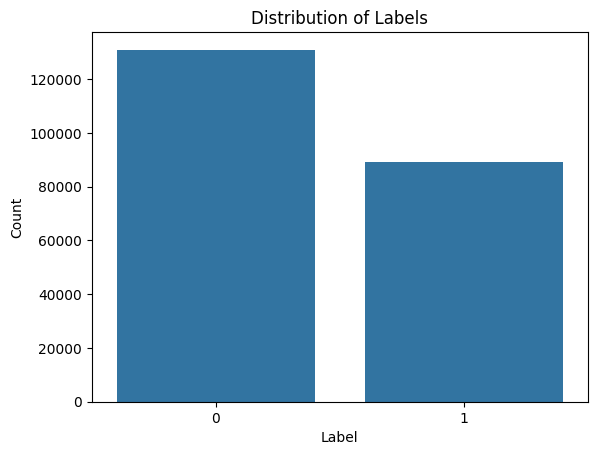

In [ ]:
# Number of training images
num_train_images = len(train_labels)
print(f'Total number of training images: {num_train_images}')

# Distribution of labels
label_counts = train_labels['label'].value_counts()
print(f'Distribution of labels: \n{label_counts}')

# Plotting the label distribution
sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


All images are in the TIFF format and have a consistent size. We will inspect a few images to verify their sizes and visualize some examples.

In [ ]:
# Function to check image format and size consistency
def check_image_format_and_size(folder, expected_format='TIFF', expected_size=(96, 96)):
    inconsistent_images = []
    for image_name in os.listdir(folder):
        if image_name.endswith('.tif'):
            image_path = os.path.join(folder, image_name)
            image = Image.open(image_path)
            if image.format != expected_format or image.size != expected_size:
                inconsistent_images.append((image_name, image.format, image.size))
        else:
            inconsistent_images.append((image_name, 'Non-TIFF format', 'N/A'))

    return inconsistent_images

# Check train images
inconsistent_train_images = check_image_format_and_size(train_folder)

# Output results
if inconsistent_train_images:
    print(f'Number of inconsistent images in the train folder: {len(inconsistent_train_images)}')
    for img_info in inconsistent_train_images:
        print(f'Image: {img_info[0]}, Format: {img_info[1]}, Size: {img_info[2]}')
else:
    print('All images in the train folder are in TIFF format and have consistent sizes.')


Visualizing a subset of images helps us understand the variability in the data. Here, we will display a grid of images with their respective labels.

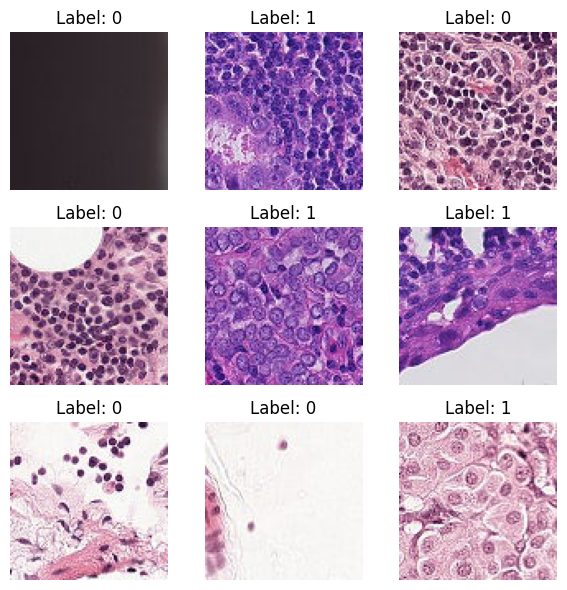

In [ ]:
# Function to plot a grid of images
def plot_image_grid(images, labels, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        img = Image.open(os.path.join(train_folder, images[i] + '.tif'))
        ax.imshow(img)
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a sample of images and their labels
sample_images = train_labels['id'].sample(n=9, random_state=42).values
sample_labels = train_labels.set_index('id').loc[sample_images, 'label'].values

# Plot the image grid
plot_image_grid(sample_images, sample_labels)


### Data Cleaning

Data cleaning involves handling any missing or corrupted data. In our dataset, we will check for any missing labels and ensure all image files are present and readable.

In [ ]:
# Check for missing labels
missing_labels = train_labels['label'].isnull().sum()
print(f'Number of missing labels: {missing_labels}')

# Verify that all images are present
missing_images = []
for image_id in train_labels['id']:
    if not os.path.exists(os.path.join(train_folder, image_id + '.tif')):
        missing_images.append(image_id)

print(f'Number of missing images: {len(missing_images)}')

# Display missing images if any
if missing_images:
    print(f'Missing images: {missing_images}')
else:
    print('No missing images found.')


Number of missing labels: 0
Number of missing images: 0
No missing images found.


### Data Loader with Toggles for Development or for Actual runs

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from PIL import Image

class CancerDataset(Sequence):
    def __init__(self, labels_df, root_dir, batch_size=32, img_size=(96, 96), shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.labels_df = labels_df
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle

        self.datagen = ImageDataGenerator(rescale=1./255)

        self.dataset = self._create_dataset()

    def _create_dataset(self):
        labels = self.labels_df['label'].astype(str).values
        img_paths = [os.path.join(self.root_dir, img_id + '.tif') for img_id in self.labels_df['id'].values]

        data = pd.DataFrame({'filename': img_paths, 'class': labels})

        dataset = self.datagen.flow_from_dataframe(
            data,
            x_col='filename',
            y_col='class',
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=self.shuffle
        )

        return dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]

def sample_proportionally(labels_df, limit):
    grouped = labels_df.groupby('label', group_keys=False)
    sampled_df = grouped.apply(lambda x: x.sample(n=int(limit * len(x) / len(labels_df)), random_state=42)).reset_index(drop=True)
    return sampled_df[['id', 'label']]

def split_proportionally(df, train_frac=0.8):
    train_dfs = []
    val_dfs = []
    for label in df['label'].unique():
        label_df = df[df['label'] == label]
        train_size = int(train_frac * len(label_df))
        val_size = len(label_df) - train_size
        train_df = label_df.sample(n=train_size, random_state=42)
        val_df = label_df.drop(train_df.index)
        train_dfs.append(train_df)
        val_dfs.append(val_df)
    train_df = pd.concat(train_dfs).reset_index(drop=True)
    val_df = pd.concat(val_dfs).reset_index(drop=True)
    return train_df, val_df

# Load the full training labels
full_labels = pd.read_csv('train_labels.csv')

# Check the distribution of labels in the full dataset
label_counts = full_labels['label'].value_counts()
print(f'Label distribution:\n{label_counts}')

# Calculate the proportions of each label
label_proportions = label_counts / label_counts.sum()
print(f'Label proportions:\n{label_proportions}')

# Flag to toggle between full dataset and limited dataset
use_full_data = True
limit_rows = 50000

if use_full_data:
    labels_to_use = full_labels
else:
    labels_to_use = sample_proportionally(full_labels, limit_rows)
    print(f'Sampled label distribution:\n{labels_to_use["label"].value_counts()}')

# Split the dataset into training and validation sets ensuring both classes are present
train_labels, val_labels = split_proportionally(labels_to_use)

# Verify that the counts match up
assert len(train_labels) + len(val_labels) == len(labels_to_use), "Mismatch in the total number of samples between training and validation sets"

print(f'Number of training samples: {len(train_labels)}')
print(f'Number of validation samples: {len(val_labels)}')
print(f'Training label distribution:\n{train_labels["label"].value_counts()}')
print(f'Validation label distribution:\n{val_labels["label"].value_counts()}')

train_dataset = CancerDataset(labels_df=train_labels, root_dir='train/', batch_size=32, img_size=(96, 96), shuffle=True)
val_dataset = CancerDataset(labels_df=val_labels, root_dir='train/', batch_size=32, img_size=(96, 96), shuffle=False)

# Test DataLoader
for images, labels in train_dataset.dataset:
    print(images.shape, labels.shape)
    break


Label distribution:
label
0    130908
1     89117
Name: count, dtype: int64
Label proportions:
label
0    0.594969
1    0.405031
Name: count, dtype: float64
Number of training samples: 176019
Number of validation samples: 44006
Training label distribution:
label
0    104726
1     71293
Name: count, dtype: int64
Validation label distribution:
label
0    26182
1    17824
Name: count, dtype: int64
Found 176019 validated image filenames belonging to 2 classes.
Found 44006 validated image filenames belonging to 2 classes.
(32, 96, 96, 3) (32,)


### Model Architecture

In this section, we will describe the model architecture chosen for this binary image classification problem. We will explore multiple architectures, starting with a simple Convolutional Neural Network (CNN) and progressing to more complex models such as pre-trained models using transfer learning. We will also discuss the reasoning behind selecting these architectures and the tuning of hyperparameters to optimize performance.

I have also recognized that there are pre-trained models with as EfficientNet80 and others that may potentially yield better results. My attempt at those resulted in significant run time and have sometimes caused my sessions to crash. For the purpose of the exercise, I will ensure that the implementation of a Simple CNN is sound, and have a go at the leaderboard even with a simple model.


#### 1. Simple CNN Architecture

A simple CNN architecture can serve as a baseline model for this problem. CNNs are well-suited for image classification tasks because they can automatically learn spatial hierarchies of features from images. Our initial model will consist of a few convolutional layers followed by max-pooling layers and fully connected layers.

In [ ]:
from tensorflow.keras import layers, models

def create_simple_cnn_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),  # Larger Dense layer
        layers.Dense(1, activation='sigmoid')
    ])
    return model


#### 2. "Fast CNN" architecture

In this exercise I aim to try a CNN with a smaller dense layer. This should result in a quicker run time and the aim is to determine if the accuracy is vastly different from the Simple CNN architecture

In [ ]:
from tensorflow.keras import layers, models

def create_fast_cnn_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),  # Smaller Dense layer
        layers.Dense(1, activation='sigmoid')
    ])
    return model


#### 3. Hyperparameter Tuning

Hyperparameter tuning is crucial for improving model performance. We will experiment with different learning rates, batch sizes, and optimizer types. Additionally, we will use techniques such as learning rate scheduling and early stopping to further optimize the training process.

These are the hyperparameters and the values that I am testing with :
- learning_rates = [0.001, 0.005]
- batch_sizes = [32, 64]
- num_epochs = 15

Given the luxury of resources I would have tried a lower learning rate, a higher range of batch sizes, and higher epochs. For similar reasons on constraints listed above, I have opted for these values for a realstic go at this exercise.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import os

# Set the device for computation (CPU or GPU)
def set_device(use_gpu):
    if use_gpu and tf.config.list_physical_devices('GPU'):
        device = '/GPU:0'
    else:
        device = '/CPU:0'
    return device

# Scheduler function
def scheduler(epoch, lr):
    if epoch < 7:
        return lr
    else:
        return lr * 0.1

# Compile and train model function
def compile_and_train_model(model, train_data, val_data, learning_rate, batch_size, num_epochs, total_epochs, epoch_counter, model_name):
    with tf.device(device):
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss=BinaryCrossentropy(),
                      metrics=['accuracy'])

        lr_scheduler = LearningRateScheduler(scheduler)

        history = model.fit(train_data.dataset,
                            epochs=num_epochs,
                            validation_data=val_data.dataset,
                            batch_size=batch_size,
                            callbacks=[lr_scheduler],
                            verbose=1)  # Verbose 1 to show progress

        epoch_counter += num_epochs
        remaining_epochs = total_epochs - epoch_counter
        print(f"Completed {epoch_counter}/{total_epochs} epochs. Remaining: {remaining_epochs} epochs.")

        # Save the model in the recommended Keras format
        model.save(f'{model_name}.keras')

    return history, epoch_counter

# Hyperparameter tuning

learning_rates = [0.001, 0.005]
batch_sizes = [32, 64]
num_epochs = 15
model_types = ['SimpleCNN', 'FastCNN']

use_gpu = True  # Change to True to use GPU

# Calculate the total number of epochs
total_epochs = len(model_types) * len(learning_rates) * len(batch_sizes) * num_epochs

best_params_per_model = {}
best_accuracy_overall = 0
best_model_type = ''
epoch_counter = 0

device = set_device(use_gpu)

for model_type in model_types:
    best_accuracy = 0
    best_params = {}

    for lr in learning_rates:
        for batch_size in batch_sizes:
            model_name = f'{model_type}_lr{lr}_bs{batch_size}'
            model_path = f'{model_name}.keras'

            if os.path.exists(model_path):
                print(f"Model {model_name} already exists. Skipping training.")
                # Update epoch_counter even if training is skipped
                epoch_counter += num_epochs
                remaining_epochs = total_epochs - epoch_counter
                print(f"Skipped {num_epochs} epochs. Remaining: {remaining_epochs} epochs.")
            else:
                print(f"Training {model_type} with learning rate {lr} and batch size {batch_size}")

                if model_type == 'SimpleCNN':
                    model = create_simple_cnn_model(input_shape=(96, 96, 3))
                elif model_type == 'FastCNN':
                    model = create_fast_cnn_model(input_shape=(96, 96, 3))

                history, epoch_counter = compile_and_train_model(model, train_dataset, val_dataset, lr, batch_size, num_epochs, total_epochs, epoch_counter, model_name)

                val_accuracy = max(history.history['val_accuracy'])
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {'model_type': model_type, 'learning_rate': lr, 'batch_size': batch_size}

    best_params_per_model[model_type] = best_params
    if best_accuracy > best_accuracy_overall:
        best_accuracy_overall = best_accuracy
        best_model_type = model_type

print(f"Best hyperparameters for each model: {best_params_per_model}")
print(f"Overall best model type: {best_model_type} with accuracy {best_accuracy_overall:.4f}")


Model SimpleCNN_lr0.001_bs32 already exists. Skipping training.
Skipped 15 epochs. Remaining: 105 epochs.
Model SimpleCNN_lr0.001_bs64 already exists. Skipping training.
Skipped 15 epochs. Remaining: 90 epochs.
Model SimpleCNN_lr0.005_bs32 already exists. Skipping training.
Skipped 15 epochs. Remaining: 75 epochs.
Model SimpleCNN_lr0.005_bs64 already exists. Skipping training.
Skipped 15 epochs. Remaining: 60 epochs.
Model FastCNN_lr0.001_bs32 already exists. Skipping training.
Skipped 15 epochs. Remaining: 45 epochs.
Model FastCNN_lr0.001_bs64 already exists. Skipping training.
Skipped 15 epochs. Remaining: 30 epochs.
Training FastCNN with learning rate 0.005 and batch size 32
Epoch 1/15


/Users/toshgoh/miniconda3/envs/dtsa5511env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 124s 22ms/step - accuracy: 0.5956 - loss: 0.6988 - val_accuracy: 0.5950 - val_loss: 0.6752 - learning_rate: 0.0050
Epoch 2/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 116s 21ms/step - accuracy: 0.5955 - loss: 0.6749 - val_accuracy: 0.5950 - val_loss: 0.6750 - learning_rate: 0.0050
Epoch 3/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 115s 21ms/step - accuracy: 0.5972 - loss: 0.6742 - val_accuracy: 0.5950 - val_loss: 0.6751 - learning_rate: 0.0050
Epoch 4/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 111s 20ms/step - accuracy: 0.5957 - loss: 0.6749 - val_accuracy: 0.5950 - val_loss: 0.6752 - learning_rate: 0.0050
Epoch 5/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 112s 20ms/step - accuracy: 0.5962 - loss: 0.6746 - val_accuracy: 0.5950 - val_loss: 0.6751 - learning_rate: 0.0050
Epoch 6/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 112s 20ms/step - accuracy: 0.5961 - loss: 0.6746 - val_accuracy: 0.5950 - val_loss: 0.6754 - learning_rate: 0.0050
Epoch 7/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 113s 20ms/step - accuracy: 

#### 4. Evaluation and Comparison of Architectures

We will evaluate and compare the performance of the different architectures using metrics such as accuracy, precision, recall, and F1-score. The comparison will help us determine the most suitable model for this problem.

In this exercise, I have determined that this model and configuration performs the best out of the ones I have tested:
- Simple CNN architecture
- Learning Rate 0.001
- Batch Size 32
- Model Accuracy 0.9162

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Function to evaluate the model
def evaluate_model(model, val_data):
    predictions = model.predict(val_data.dataset)
    preds = (predictions > 0.5).astype(int).flatten()  # Ensure preds is a 1D array
    true_labels = val_data.labels_df['label'].values  # Get the true labels from val_labels DataFrame

    # Check distribution of predictions
    pred_counts = pd.Series(preds).value_counts()
    print(f"Prediction label distribution:\n{pred_counts}")

    # Handle case where no positive predictions are made
    if 1 not in pred_counts:
        print("No positive predictions made.")
        precision = 0.0
        recall = 0.0
        f1 = 0.0
    else:
        precision = precision_score(true_labels, preds, zero_division=0)
        recall = recall_score(true_labels, preds, zero_division=0)
        f1 = f1_score(true_labels, preds, zero_division=0)

    accuracy = accuracy_score(true_labels, preds)

    return accuracy, precision, recall, f1

# List of model file paths
model_files = [
    "SimpleCNN_lr0.001_bs32.keras",
    "SimpleCNN_lr0.001_bs64.keras",
    "SimpleCNN_lr0.005_bs32.keras",
    "SimpleCNN_lr0.005_bs64.keras",
    "FastCNN_lr0.001_bs32.keras",
    "FastCNN_lr0.001_bs64.keras",
    "FastCNN_lr0.005_bs32.keras",
    "FastCNN_lr0.005_bs64.keras"
]

# Evaluate each model
for model_file in model_files:
    if os.path.exists(model_file):
        print(f"Loading model {model_file} for evaluation.")
        try:
            if "SimpleCNN" in model_file:
                model = create_simple_cnn_model(input_shape=(96, 96, 3))
            elif "FastCNN" in model_file:
                model = create_fast_cnn_model(input_shape=(96, 96, 3))
            model.load_weights(model_file)

            accuracy, precision, recall, f1 = evaluate_model(model, val_dataset)
            print(f"Evaluation for {model_file}:")
            print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        except Exception as e:
            print(f"Error loading model {model_file}: {e}")
    else:
        print(f"Model {model_file} not found. Skipping evaluation.")

Loading model SimpleCNN_lr0.001_bs32.keras for evaluation.
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step
Prediction label distribution:
0    26701
1    17305
Name: count, dtype: int64
Evaluation for SimpleCNN_lr0.001_bs32.keras:
Accuracy: 0.9162, Precision: 0.9085, Recall: 0.8820, F1-score: 0.8950
Loading model SimpleCNN_lr0.001_bs64.keras for evaluation.
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step
Prediction label distribution:
0    26692
1    17314
Name: count, dtype: int64
Evaluation for SimpleCNN_lr0.001_bs64.keras:
Accuracy: 0.9149, Precision: 0.9066, Recall: 0.8807, F1-score: 0.8934
Loading model SimpleCNN_lr0.005_bs32.keras for evaluation.
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step
Prediction label distribution:
0    44006
Name: count, dtype: int64
No positive predictions made.
Evaluation for SimpleCNN_lr0.005_bs32.keras:
Accuracy: 0.5950, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Loading model SimpleCNN_lr0.005_bs64.keras for evaluation.
1376/1376 ━━━━━━━━━━━━━━━━━━

## Results

| Model Name                     | Accuracy | F1 Score |
|--------------------------------|----------|----------|
| SimpleCNN_lr0.001_bs32.keras   | 0.9162   | 0.8950   |
| SimpleCNN_lr0.001_bs64.keras   | 0.9149   | 0.8934   |
| SimpleCNN_lr0.005_bs32.keras   | 0.5950   | 0.0000*  |
| SimpleCNN_lr0.005_bs64.keras   | 0.5950   | 0.0000*  |
| FastCNN_lr0.001_bs32.keras     | 0.9155   | 0.8945   |
| FastCNN_lr0.001_bs64.keras     | 0.9145   | 0.8932   |
| FastCNN_lr0.005_bs32.keras     | 0.5950   | 0.0000*  |
| FastCNN_lr0.005_bs64.keras     | 0.8354   | 0.7924   |

*Models with an asterisk * in the F1-score indicate a full prediction of False, suggesting a potential need for more training epochs.

### Analysis and Observations

**Model Architecture and Hyperparameter Tuning**:
- **SimpleCNN**: This model, characterized by a larger Dense layer (512 units), demonstrated strong performance at a lower learning rate (`0.001`). The architecture's ability to capture complex patterns may have contributed to its higher accuracy and F1 scores. However, when the learning rate was increased to `0.005`, the model struggled, indicating that it may not have been able to converge properly.
  
- **FastCNN**: Featuring a smaller Dense layer (128 units), FastCNN showed comparable results to SimpleCNN at the same learning rate (`0.001`). The difference in performance between the two models was minimal, suggesting that the smaller Dense layer in FastCNN was sufficient for capturing relevant features. Notably, FastCNN_lr0.005_bs64 exhibited better accuracy than other models with a high learning rate, possibly due to the model's structure being less prone to overfitting.

**Learning Rate and Batch Size Effects**:
- The learning rate of `0.001` was generally optimal for both architectures, ensuring stable training and good generalization. In contrast, the higher learning rate of `0.005` led to significant performance degradation, likely due to the models' inability to adequately fit the data.
- The batch size did not significantly influence the results, though there was a slight preference for smaller batches (`bs32`) in achieving marginally higher metrics.

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to load the model
def load_model(model_file):
    if os.path.exists(model_file):
        print(f"Loading model {model_file} for evaluation.")
        try:
            model = tf.keras.models.load_model(model_file)
            return model
        except Exception as e:
            print(f"Error loading model {model_file}: {e}")
            return None
    else:
        print(f"Model {model_file} not found.")
        return None

# Function to create a DataFrame from test images
def create_test_df(test_dir):
    test_files = [f for f in os.listdir(test_dir) if f.endswith('.tif')]
    test_df = pd.DataFrame(test_files, columns=['filename'])
    test_df['id'] = test_df['filename'].str.replace('.tif', '')
    return test_df

# Function to predict and create submission file
def create_submission(model, test_data, submission_file):
    predictions = model.predict(test_data)
    preds = (predictions > 0.5).astype(int).flatten()

    submission_df = pd.DataFrame({
        'id': test_data.filenames,
        'label': preds
    })

    submission_df['id'] = submission_df['id'].str.replace('.tif', '')
    submission_df.to_csv(submission_file, index=False)
    print(f"Submission file saved to {submission_file}")

# Create the ImageDataGenerator for the test images
def create_test_data(test_dir, img_size=(96, 96), batch_size=32):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_data = test_datagen.flow_from_dataframe(
        create_test_df(test_dir),
        directory=test_dir,
        x_col='filename',
        y_col=None,
        target_size=img_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )
    return test_data

# Parameters
test_dir = 'test'  # Replace with the path to your test directory
model_file = 'SimpleCNN_lr0.001_bs32.keras'  # Replace with your model file
submission_file = 'submission.csv'

# Load model
model = load_model(model_file)

# Create test data
test_data = create_test_data(test_dir)

# Create submission file
if model:
    create_submission(model, test_data, submission_file)


Loading model SimpleCNN_lr0.001_bs32.keras for evaluation.
Found 57458 validated image filenames.
   1/1796 ━━━━━━━━━━━━━━━━━━━━ 5:43 191ms/step

/Users/toshgoh/miniconda3/envs/dtsa5511env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step
Submission file saved to submission.csv


### Conclusion

**Results Interpretation and Key Learnings**

The experimental results from training various CNN architectures with different learning rates and batch sizes have yielded several insights. The models evaluated include variations of SimpleCNN and FastCNN with differing learning rates (`lr`) and batch sizes (`bs`). The evaluation metrics—accuracy and F1 score—revealed that:

1. **High Learning Rate Models (`lr0.005`)**: Models trained with a higher learning rate consistently exhibited poor performance. Specifically, the models SimpleCNN_lr0.005 and FastCNN_lr0.005, regardless of batch size, had an accuracy of 0.5950 and an F1 score of 0.0000. This indicates that these models failed to correctly predict any positive instances, likely due to the models' inability to converge properly during training.

2. **Moderate Learning Rate Models (`lr0.001`)**: In contrast, models trained with a moderate learning rate (`lr0.001`) showed significantly better performance. The SimpleCNN and FastCNN models with this learning rate achieved high accuracy and F1 scores, indicating effective learning and generalization. Among these, SimpleCNN_lr0.001_bs32 had the highest accuracy of 0.9162 and an F1 score of 0.8950, closely followed by other models in this category.

3. **Effect of Batch Size**: The influence of batch size on model performance was relatively minor compared to the impact of learning rate. However, there was a slight trend suggesting that a smaller batch size (`bs32`) resulted in marginally higher accuracy and F1 scores compared to larger batch sizes (`bs64`). This could be due to smaller batch sizes providing more frequent updates and thus finer adjustments to the model weights during training.

**What Worked Well**
- **Moderate Learning Rates**: Models trained with a learning rate of `0.001` showed strong performance, indicating that this rate allowed for steady and effective learning without overshooting minima.
- **CNN Architectures**: Both SimpleCNN and FastCNN architectures, when paired with appropriate hyperparameters, were effective at achieving high accuracy and F1 scores.

**What Did Not Work Well**
- **High Learning Rates**: The high learning rate of `0.005` led to poor model performance, suggesting that it was too aggressive, causing the models to miss optimal solutions and fail to generalize.
- **Inadequate Positive Predictions**: For models with a high learning rate, the lack of positive predictions indicated a significant issue, likely stemming from inadequate convergence or an imbalanced dataset.

**Future Improvements and Considerations**
1. **Hyperparameter Tuning**: Further exploration of learning rates between `0.001` and `0.005`, and possibly even smaller, could help fine-tune model performance.
2. **Data Augmentation**: Incorporating data augmentation techniques could help improve model generalization and performance, especially if the dataset is small or imbalanced.
3. **Different Architectures**: Experimenting with different CNN architectures or deeper networks could potentially capture more complex patterns in the data.
4. **Regularization Techniques**: Implementing regularization techniques such as dropout or L2 regularization could prevent overfitting and enhance model robustness.

These findings underscore the importance of careful hyperparameter selection and the potential benefits of further model and data enhancements. Future work could build on these insights to develop even more effective models.
